In [1]:
from collections import deque
import numpy as np
import pandas as pd
import seaborn as sns
import random
import pickle


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import wandb

In [2]:
MEM_SIZE = 5000
MIN_MEM_SIZE = 1000
DISCOUNT = 0.90
EPSILON_START = 1
EPSILON_END = 0.05
EPSILON_STOP = 300

EPISODES = 50
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

In [3]:
%run tetris-environment.ipynb

          
          
          
          
          
          
          
          
          
          
          
          
          
          
          
          
          
███  █████
███   ████
████ █████
          
          
          
          
          
          
          
          
          
 █        
███       
          
          
          
          
          
          
███  █████
███   ████
████ █████


In [4]:
# layer initialisation
def init_linear_layer(m, method):
    torch.nn.init.xavier_normal_(m.weight, nn.init.calculate_gain(method))
    torch.nn.init.constant_(m.bias, 0)
    return m

In [5]:
model = nn.Sequential(
    init_linear_layer(nn.Linear(20*10, 128), 'relu'),
    nn.ReLU(),
    init_linear_layer(nn.Linear(128, 64), 'relu'),
    nn.ReLU(),
    init_linear_layer(nn.Linear(64, 1), 'linear')
)

In [6]:
def get_best_state(states):
    q_values = model(states)
    return torch.argmax(q_values)

In [7]:
env = TetrisEnv()

### Fill the replay buffer by playing games

In [8]:
replay_buffer = []

def to_torch(state):
    return torch.from_numpy(states.reshape(states.shape[0], -1)).float()

with tqdm(total=MIN_MEM_SIZE/20) as pbar:
    while len(replay_buffer) < MIN_MEM_SIZE:
        env.reset()
        pbar.update(1)

        # play moves until game over
        while True:
            states, scores, clears, dones = env.get_next_states()

            chosen_index = get_best_state(torch.from_numpy(states.reshape(-1, 200)).float())

            replay_buffer.append((env.get_current_state(), states[chosen_index], scores[chosen_index], dones[chosen_index]))

            if dones[chosen_index]:
                break
            else:
                env.step(states[chosen_index], clears[chosen_index], scores[chosen_index])

# states, _, _, _, = env.get_next_states()
# states = torch.from_numpy(states.reshape(states.shape[0], -1)).float()

# model(states)

  0%|          | 0/50.0 [00:00<?, ?it/s]

In [ ]:
# with gzip.GzipFile('buffer.bin', 'wb', compresslevel=1) as gzipFile:
#     pickle.dump(replay_buffer, gzipFile)

### Fill the replay buffer by loading from file

In [32]:
# len(replay_buffer)

1003

### Training loop

In [9]:
wandb.init(project='tetris-dqn', config={
    'learning-rate': LEARNING_RATE,
    'batch-size': BATCH_SIZE,
    'replay-max-size': MEM_SIZE,
    'replay-min-size': MIN_MEM_SIZE,
    'discound-factor': DISCOUNT
})

wandb: Currently logged in as: fischly. Use `wandb login --relogin` to force relogin


  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='loss'>

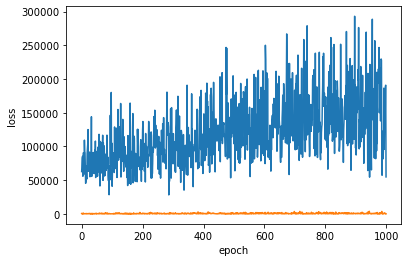

In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

training_loss = []
training_scores = []


for episode in tqdm(range(1000)): # tqdm(range(EPISODES)):
    # play another game
    env.reset()
    while True:
        states, scores, clears, dones = env.get_next_states()

        chosen_index = get_best_state(torch.from_numpy(states.reshape(-1, 200)).float())

        replay_buffer.append((env.get_current_state(), states[chosen_index], scores[chosen_index], dones[chosen_index]))

        if dones[chosen_index]:
            training_scores.append({'epoch': episode, 'score': env.score})
            break
        else:
            env.step(states[chosen_index], clears[chosen_index], scores[chosen_index])
    
    if len(replay_buffer) > MEM_SIZE:
        replay_buffer = replay_buffer[int(MEM_SIZE/10):]
    
    
    # take sample from replay memory
    batch = random.sample(replay_buffer, BATCH_SIZE)

    current_states = torch.from_numpy(np.array([s[0].reshape(200) for s in batch])).float()
    next_states = torch.from_numpy(np.array([s[1].reshape(200) for s in batch])).float()

    next_q_values = model(next_states)
    y_hat = model(current_states)

    # calculate expected q value
    y = []
    for i, (state, _, score, done) in enumerate(batch):
        if not done:
            new_q = score + DISCOUNT * next_q_values[i]
        else:
            new_q = score

        y.append(new_q)

    # fit the model to the expected q value
    loss = criterion(y_hat, torch.tensor(y).reshape(128, 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    wandb.log({'game/score': env.score, 'training/loss': loss.item()})
    training_loss.append({'epoch': episode, 'loss': loss.item()})
    # print(loss)
    
sns.lineplot(data=pd.DataFrame(training_loss), x='epoch', y='loss')
sns.lineplot(data=pd.DataFrame(training_scores), x='epoch', y='score')

<AxesSubplot:xlabel='epoch', ylabel='score'>

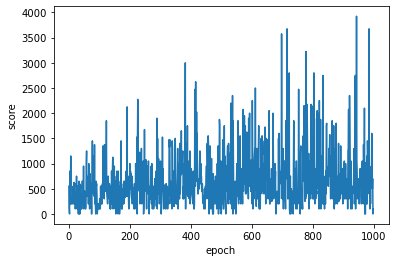

In [13]:
sns.lineplot(data=pd.DataFrame(training_scores), x='epoch', y='score')

In [17]:

env.reset()
print(env.current_piece)

while True:
    states, scores, clears, dones = env.get_next_states()

    chosen_index = get_best_state(torch.from_numpy(states.reshape(-1, 200)).float())

    env._print_state(states[chosen_index])
    print()
    
    # replay_buffer.append((env.get_current_state(), states[chosen_index], scores[chosen_index], dones[chosen_index]))

    if dones[chosen_index]:
        print(f'Score: {env.score}')
        break
    else:
        env.step(states[chosen_index], clears[chosen_index], scores[chosen_index])

0
          
          
          
          
          
          
          
          
          
          
          
          
          
          
          
          
          
 █        
██        
 █        

          
          
          
          
          
          
          
          
          
          
          
          
          
          
          
 ██       
 ██       
 █        
██        
 █        

          
          
          
          
          
          
          
          
          
          
          
          
          
  █       
  ███     
 ██       
 ██       
 █        
██        
 █        

          
          
          
          
          
          
          
          
          
          
          
          
          
  █ ██    
  ████    
 ██  █    
 ██       
 █        
██        
 █        

          
          
          
          
          
          
          
          
          
          
    